In [52]:
import pandas as pd
import numpy as np
import pickle

In [53]:
# Load the Dataset

df = pd.read_csv("dataset/Churn_Modelling.csv")

In [54]:
# Remove Column which are not necessary
df.drop(["RowNumber","CustomerId" ,"Surname"] , axis=1 , inplace=True)

In [55]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [56]:
# Encode the categorical data
from sklearn.preprocessing import LabelEncoder


encoders = {}

for column in df.columns:
    if df[column].dtype == "object":
        
        encoder = LabelEncoder()

        df[column] = encoder.fit_transform(df[column])
        encoders[column] = encoder

# Also save the encoders as pickle which will be used in 
# future when model is deployed and predictions are to be done

with open("encoders.pkl" , "wb") as f:
    pickle.dump(encoders , file=f)
# Decode data code
# encoders['Geography'].inverse_transform([0])

In [57]:
# Or we can one hot encode the data
from sklearn.preprocessing import OneHotEncoder


temp_df = df.copy()

ohe = OneHotEncoder()

geography_ohe =  ohe.fit_transform(temp_df[['Geography']])

ohe_array = geography_ohe.toarray()
columns = ohe.get_feature_names_out()

ohe_df = pd.DataFrame(data=ohe_array , columns=columns , dtype="int64")

temp_df = pd.concat([temp_df , ohe_df] , axis=1).drop(columns=["Geography"])

temp_df.head()

# Similarly we can perform OHE or Label encoding for Gender column as well


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_0,Geography_1,Geography_2
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [58]:
from sklearn.model_selection import train_test_split


X = df.drop("Exited" , axis=1)
y = df['Exited']


x_train , x_test , y_train , y_test = train_test_split(X , y , test_size=0.3 , random_state=42 , shuffle=True)

print(x_train.shape , y_train.shape)

(7000, 10) (7000,)


In [59]:
from sklearn.preprocessing import StandardScaler


scaler= StandardScaler()


x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


# Save the scaler in pickle file
with open("scaler.pkl" , "wb") as f:
    pickle.dump(scaler , f)


In [ ]:
# Build Neural network

import tensorflow
from keras.models import Sequential
from keras.layers import Dense , Input
from keras.callbacks import EarlyStopping , TensorBoard


In [72]:
model = Sequential()

model.add(Input(shape=(x_train_scaled.shape[1] ,)))
# It is a good practise to= take neurons in first layer greater than or equal to the features we have
model.add(Dense(units=x_train_scaled.shape[1] , activation="relu"))
model.add(Dense(units=64 , activation="relu"))
model.add(Dense(units=32 , activation="relu"))
model.add(Dense(units=1 , activation="sigmoid")) # Classification problem



model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,927 (11.43 KB)

 Trainable params: 2,927 (11.43 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
from keras.optimizers import Adam

adam = Adam(learning_rate = 0.1)
model.compile(optimizer=adam , loss="binary_crossentropy" , metrics=['accuracy'])

In [75]:

# If the model has reached certain accuracy until an "n" number of epcohs and after that if accuracy starts reducing or loss is not reducing 
# then early stops training early to retain best accuracy

early_stopping = EarlyStopping(monitor="val_loss", patience=10 , restore_best_weights=True)

history = model.fit(x_train_scaled , y_train , epochs=100,validation_data=(x_test_scaled , y_test) , callbacks=[early_stopping] )



Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7908 - loss: 0.5147 - val_accuracy: 0.8053 - val_loss: 0.4946
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7877 - loss: 0.5191 - val_accuracy: 0.8053 - val_loss: 0.4943
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7850 - loss: 0.5224 - val_accuracy: 0.8053 - val_loss: 0.4930
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7958 - loss: 0.5082 - val_accuracy: 0.8053 - val_loss: 0.4929
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7860 - loss: 0.5209 - val_accuracy: 0.8053 - val_loss: 0.4935
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7880 - loss: 0.5182 - val_accuracy: 0.8053 - val_loss: 0.4936
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7909 - loss: 0.5144 - val_accuracy: 0.8053 - val_loss: 0.4966
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7948 - loss: 0.5085 - val_accu

In [77]:
model.save('model.keras')

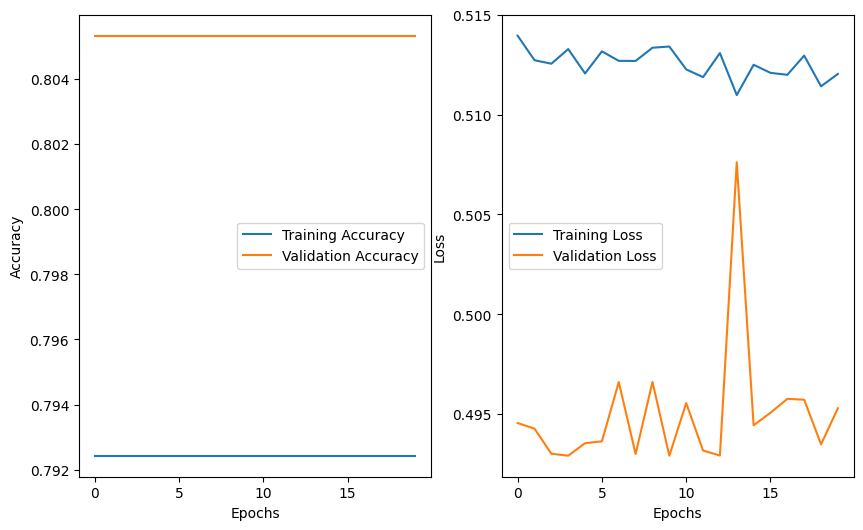

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10,6])

# Plotting Accuracy
plt.subplot(1, 2, 1)  # Create a subplot in 1 row and 2 columns
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)  # Create a subplot in 1 row and 2 columns
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
